<a href="https://colab.research.google.com/github/Vivekchavda1374/AI/blob/main/Analytical_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip uninstall -y numpy scikit-surprise
# !pip install "numpy<2"
# !pip install --no-cache-dir scikit-surprise

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import zipfile
import psutil
from urllib import request
from surprise import SVD, KNNBasic, NMF, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, KFold

In [ ]:
np.random.seed(42)

In [ ]:
def download_movielens():
    if not os.path.exists('ml-100k'):
        print("Downloading MovieLens 100K dataset...")
        url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
        request.urlretrieve(url, "ml-100k.zip")

        print("Extracting MovieLens 100K dataset...")
        with zipfile.ZipFile("ml-100k.zip", "r") as zip_ref:
            zip_ref.extractall(".")
        print("MovieLens 100K dataset downloaded and extracted.")
    else:
        print("MovieLens 100K dataset already present.")

In [ ]:
def download_jester():

    if not os.path.exists('jester-data-1.zip') and not os.path.exists('jester-data-1.xls'):
        print("Downloading Jester dataset...")
        url = "https://goldberg.berkeley.edu/jester-data/jester-data-1.zip"
        request.urlretrieve(url, "jester-data-1.zip")

        print("Extracting Jester dataset...")
        with zipfile.ZipFile("jester-data-1.zip", "r") as zip_ref:
            zip_ref.extractall(".")
        print("Jester dataset downloaded and extracted.")
    else:
        print("Jester dataset already present or downloaded.")


In [ ]:
def load_movielens():
    """Load and prepare MovieLens dataset"""
    print("Loading MovieLens dataset...")
    # Load the ratings data
    ratings_file = 'ml-100k/u.data'
    ratings_df = pd.read_csv(ratings_file, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

    # Convert to Surprise format
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)

    return data, "MovieLens 100K"


In [ ]:

def load_jester():
    """Load and prepare Jester dataset"""
    print("Loading Jester dataset...")
    # Check if we have Excel or CSV
    if os.path.exists('jester-data-1.xls'):
        # Load the Excel file
        jester_df = pd.read_excel('jester-data-1.xls', header=None)
    else:
        # If we have the zip but extracted differently
        with zipfile.ZipFile("jester-data-1.zip", "r") as zip_ref:
            with zip_ref.open(zip_ref.namelist()[0]) as f:
                jester_df = pd.read_excel(f, header=None)

    # The first column contains the number of jokes rated by each user
    jester_df = jester_df.iloc[:, 1:]  # Remove the first column

    # Transform to long format (user, joke, rating)
    users, jokes, ratings = [], [], []
    for user_id, row in enumerate(jester_df.values):
        for joke_id, rating in enumerate(row):
            if rating != 99:  # 99 indicates missing data
                users.append(user_id)
                jokes.append(joke_id)
                ratings.append(rating)  # Ratings are on scale -10 to 10

    ratings_df = pd.DataFrame({
        'user_id': users,
        'item_id': jokes,
        'rating': ratings
    })

    # Convert to Surprise format
    reader = Reader(rating_scale=(-10, 10))
    data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)

    return data, "Jester"

In [ ]:
def evaluate_model(algo_class, algo_name, data, n_folds=5):
    """Evaluate a model on the given dataset"""
    print(f"Evaluating {algo_name}...")
    results = {
        'fit_time': [],
        'rmse': [],
        'mae': [],
        'memory': []
    }

    kf = KFold(n_splits=n_folds)

    for trainset, testset in kf.split(data):
        # Initialize the algorithm
        algo = algo_class()

        # Measure memory before fitting
        memory_before = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # MB

        # Measure fit time
        start_time = time.time()
        algo.fit(trainset)
        fit_time = time.time() - start_time

        # Measure memory after fitting
        memory_after = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # MB
        memory_used = memory_after - memory_before

        # Predict and compute metrics
        predictions = algo.test(testset)
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)

        # Store results
        results['fit_time'].append(fit_time)
        results['rmse'].append(rmse)
        results['mae'].append(mae)
        results['memory'].append(memory_used)

        print(f"  Fold completed: RMSE={rmse:.4f}, MAE={mae:.4f}, Time={fit_time:.2f}s, Memory={memory_used:.2f}MB")

    # Calculate averages
    for key in results:
        results[key] = np.mean(results[key])

    return results


In [ ]:
def compare_algorithms(dataset_name, data):
    """Compare all algorithms on a given dataset"""
    algorithms = [
        (SVD, "SVD"),
        (KNNBasic, "K-NN"),
        (NMF, "NMF")
    ]

    all_results = {}

    for algo_class, algo_name in algorithms:
        all_results[algo_name] = evaluate_model(algo_class, algo_name, data)

    return all_results


In [ ]:
def plot_comparison(movielens_results, jester_results):
    """Plot comparison of algorithms on both datasets"""
    metrics = ['fit_time', 'memory', 'rmse', 'mae']
    titles = ['Average Fit Time (s)', 'Average Memory Usage (MB)', 'Average RMSE', 'Average MAE']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    x = np.arange(3)  # 3 algorithms
    width = 0.35

    algorithms = list(movielens_results.keys())

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ml_values = [movielens_results[algo][metric] for algo in algorithms]
        js_values = [jester_results[algo][metric] for algo in algorithms]

        axes[i].bar(x - width/2, ml_values, width, label='MovieLens')
        axes[i].bar(x + width/2, js_values, width, label='Jester')

        axes[i].set_title(title)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(algorithms)
        axes[i].legend()

        # Add value labels
        for j, v in enumerate(ml_values):
            axes[i].text(j - width/2, v + 0.01, f'{v:.3f}', ha='center')
        for j, v in enumerate(js_values):
            axes[i].text(j + width/2, v + 0.01, f'{v:.3f}', ha='center')

    fig.tight_layout()
    plt.savefig('algorithm_comparison.png')
    plt.show()


In [ ]:
def main():
    # Download datasets
    download_movielens()
    download_jester()

    # Load datasets
    movielens_data, ml_name = load_movielens()
    jester_data, js_name = load_jester()

    # Evaluate algorithms on MovieLens
    print(f"\nEvaluating algorithms on {ml_name}...")
    movielens_results = compare_algorithms(ml_name, movielens_data)

    # Evaluate algorithms on Jester
    print(f"\nEvaluating algorithms on {js_name}...")
    jester_results = compare_algorithms(js_name, jester_data)

    # Print result summary
    print("\nSummary of Results:")
    print("-" * 80)
    print("MovieLens 100K Dataset:")
    for algo, metrics in movielens_results.items():
        print(f"  {algo}: Fit Time={metrics['fit_time']:.2f}s, Memory={metrics['memory']:.2f}MB, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}")

    print("\nJester Dataset:")
    for algo, metrics in jester_results.items():
        print(f"  {algo}: Fit Time={metrics['fit_time']:.2f}s, Memory={metrics['memory']:.2f}MB, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}")

    # Plot comparisons
    plot_comparison(movielens_results, jester_results)

    # Save results to CSV
    ml_df = pd.DataFrame(movielens_results).T
    ml_df.index.name = 'Algorithm'
    ml_df.to_csv('movielens_results.csv')

    js_df = pd.DataFrame(jester_results).T
    js_df.index.name = 'Algorithm'
    js_df.to_csv('jester_results.csv')

    print("\nResults saved to CSV files and visualization saved as 'algorithm_comparison.png'")


In [ ]:
if __name__ == "__main__":
    main()

MovieLens 100K dataset already present.
Jester dataset already present or downloaded.
Loading MovieLens dataset...
Loading Jester dataset...

Evaluating algorithms on MovieLens 100K...
Evaluating SVD...
RMSE: 0.9355
MAE:  0.7370
  Fold completed: RMSE=0.9355, MAE=0.7370, Time=1.04s, Memory=0.00MB
RMSE: 0.9351
MAE:  0.7352
  Fold completed: RMSE=0.9351, MAE=0.7352, Time=0.91s, Memory=0.00MB
RMSE: 0.9405
MAE:  0.7425
  Fold completed: RMSE=0.9405, MAE=0.7425, Time=1.02s, Memory=0.00MB
RMSE: 0.9374
MAE:  0.7390
  Fold completed: RMSE=0.9374, MAE=0.7390, Time=1.30s, Memory=0.00MB
RMSE: 0.9346
MAE:  0.7361
  Fold completed: RMSE=0.9346, MAE=0.7361, Time=1.41s, Memory=0.00MB
Evaluating K-NN...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9949
MAE:  0.7857
  Fold completed: RMSE=0.9949, MAE=0.7857, Time=0.21s, Memory=0.00MB
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9713
MAE:  0.7673
  Fold completed: RMSE=0.9713, MAE=0

MovieLens 100K dataset already present.
Jester dataset already present or downloaded.
Loading MovieLens dataset...
Loading Jester dataset...

Evaluating algorithms on MovieLens 100K...
Evaluating SVD...
RMSE: 0.9355
MAE:  0.7370
  Fold completed: RMSE=0.9355, MAE=0.7370, Time=0.92s, Memory=0.57MB
RMSE: 0.9351
MAE:  0.7352
  Fold completed: RMSE=0.9351, MAE=0.7352, Time=0.92s, Memory=0.00MB
RMSE: 0.9405
MAE:  0.7425
  Fold completed: RMSE=0.9405, MAE=0.7425, Time=1.08s, Memory=0.00MB
RMSE: 0.9374
MAE:  0.7390
  Fold completed: RMSE=0.9374, MAE=0.7390, Time=1.53s, Memory=0.00MB
RMSE: 0.9346
MAE:  0.7361
  Fold completed: RMSE=0.9346, MAE=0.7361, Time=0.94s, Memory=0.00MB
Evaluating NMF...
RMSE: 0.9720
MAE:  0.7651
  Fold completed: RMSE=0.9720, MAE=0.7651, Time=1.20s, Memory=0.00MB
RMSE: 0.9569
MAE:  0.7530
  Fold completed: RMSE=0.9569, MAE=0.7530, Time=1.18s, Memory=0.00MB
RMSE: 0.9628
MAE:  0.7571
  Fold completed: RMSE=0.9628, MAE=0.7571, Time=1.12s, Memory=0.00MB
RMSE: 0.9625
MAE:  

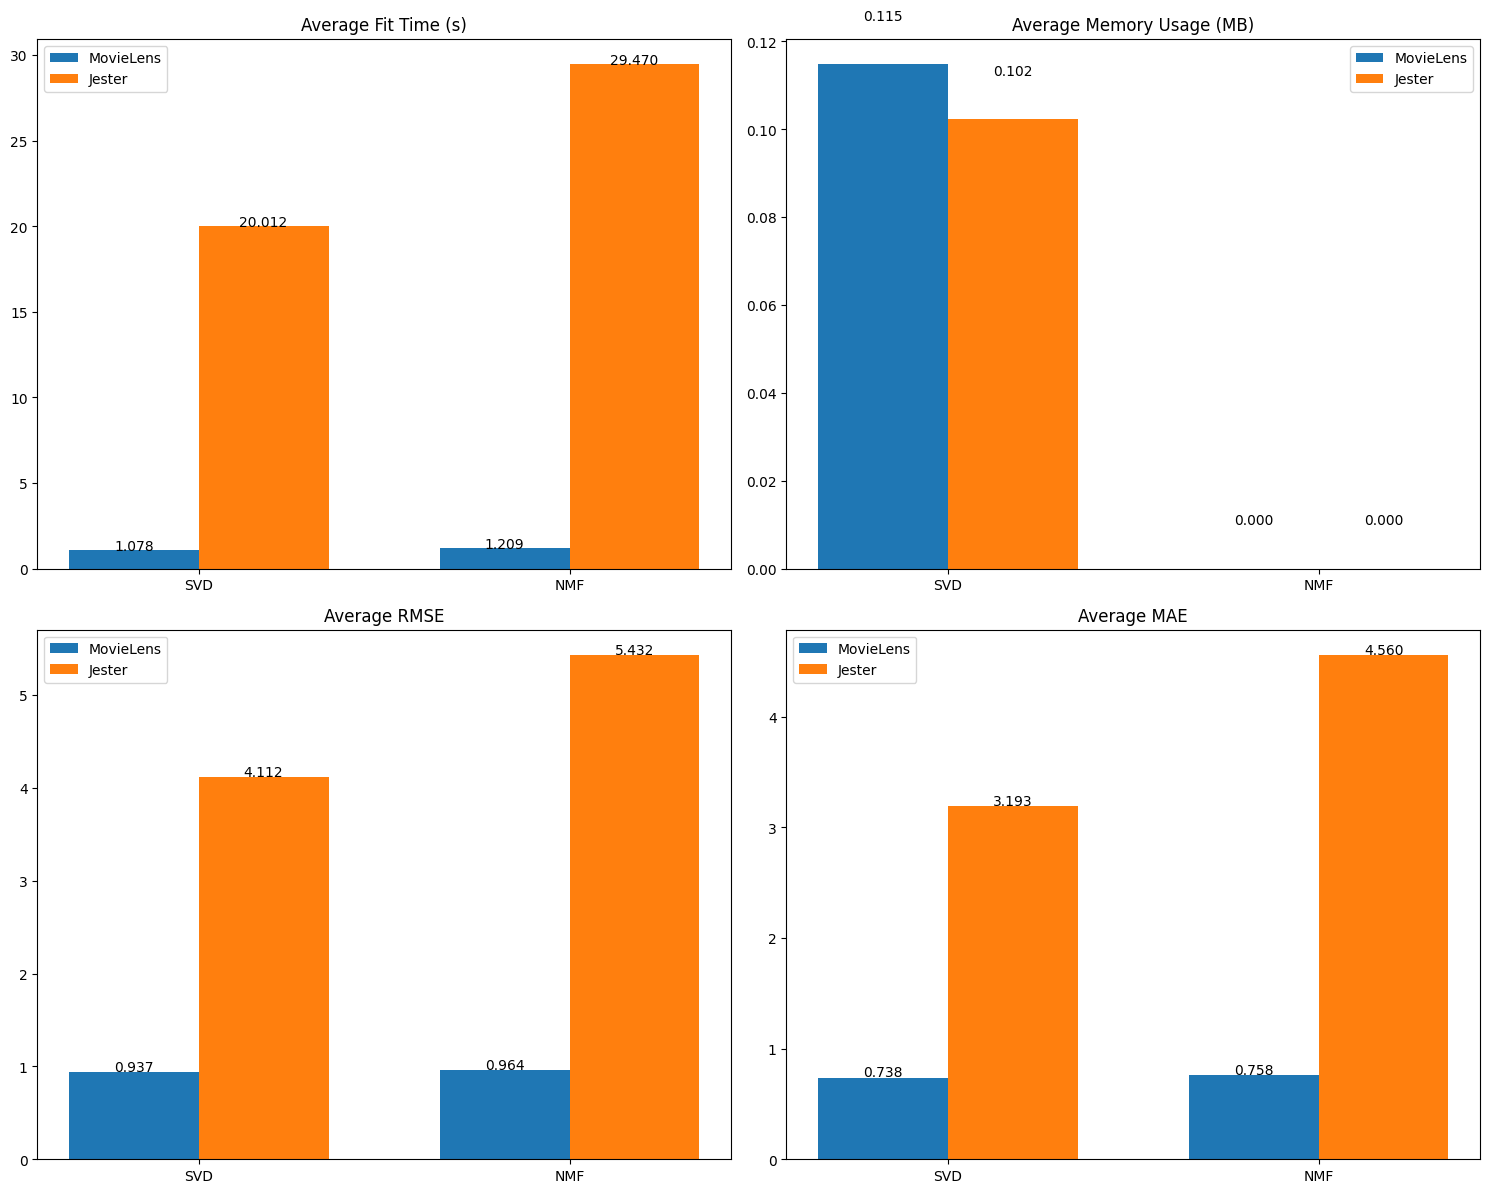


Results saved to CSV files and visualization saved as 'algorithm_comparison.png'


In [ ]:
# Recommender System Methods Comparison (SVD, NMF)
# This script compares SVD and NMF on MovieLens and Jester datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import zipfile
import psutil
from urllib import request
from surprise import SVD, NMF, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, KFold

# Set random seed for reproducibility
np.random.seed(42)

def download_movielens():
    """Download and extract MovieLens 100K dataset if not already present"""
    if not os.path.exists('ml-100k'):
        print("Downloading MovieLens 100K dataset...")
        url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
        request.urlretrieve(url, "ml-100k.zip")

        print("Extracting MovieLens 100K dataset...")
        with zipfile.ZipFile("ml-100k.zip", "r") as zip_ref:
            zip_ref.extractall(".")
        print("MovieLens 100K dataset downloaded and extracted.")
    else:
        print("MovieLens 100K dataset already present.")

def download_jester():
    """Download and extract Jester dataset if not already present"""
    if not os.path.exists('jester-data-1.zip') and not os.path.exists('jester-data-1.xls'):
        print("Downloading Jester dataset...")
        url = "https://goldberg.berkeley.edu/jester-data/jester-data-1.zip"
        request.urlretrieve(url, "jester-data-1.zip")

        print("Extracting Jester dataset...")
        with zipfile.ZipFile("jester-data-1.zip", "r") as zip_ref:
            zip_ref.extractall(".")
        print("Jester dataset downloaded and extracted.")
    else:
        print("Jester dataset already present or downloaded.")

def load_movielens():
    """Load and prepare MovieLens dataset"""
    print("Loading MovieLens dataset...")
    # Load the ratings data
    ratings_file = 'ml-100k/u.data'
    ratings_df = pd.read_csv(ratings_file, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

    # Convert to Surprise format
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)

    return data, "MovieLens 100K"

def load_jester():
    """Load and prepare Jester dataset"""
    print("Loading Jester dataset...")
    # Check if we have Excel or CSV
    if os.path.exists('jester-data-1.xls'):
        # Load the Excel file
        jester_df = pd.read_excel('jester-data-1.xls', header=None)
    else:
        # If we have the zip but extracted differently
        with zipfile.ZipFile("jester-data-1.zip", "r") as zip_ref:
            with zip_ref.open(zip_ref.namelist()[0]) as f:
                jester_df = pd.read_excel(f, header=None)

    # The first column contains the number of jokes rated by each user
    jester_df = jester_df.iloc[:, 1:]  # Remove the first column

    # Transform to long format (user, joke, rating)
    users, jokes, ratings = [], [], []
    for user_id, row in enumerate(jester_df.values):
        for joke_id, rating in enumerate(row):
            if rating != 99:  # 99 indicates missing data
                users.append(user_id)
                jokes.append(joke_id)
                ratings.append(rating)  # Ratings are on scale -10 to 10

    ratings_df = pd.DataFrame({
        'user_id': users,
        'item_id': jokes,
        'rating': ratings
    })

    # Convert to Surprise format
    reader = Reader(rating_scale=(-10, 10))
    data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)

    return data, "Jester"

def evaluate_model(algo_class, algo_name, data, n_folds=5):
    """Evaluate a model on the given dataset"""
    print(f"Evaluating {algo_name}...")
    results = {
        'fit_time': [],
        'rmse': [],
        'mae': [],
        'memory': []
    }

    kf = KFold(n_splits=n_folds)

    for trainset, testset in kf.split(data):
        # Initialize the algorithm
        algo = algo_class()

        # Measure memory before fitting
        memory_before = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # MB

        # Measure fit time
        start_time = time.time()
        algo.fit(trainset)
        fit_time = time.time() - start_time

        # Measure memory after fitting
        memory_after = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # MB
        memory_used = memory_after - memory_before

        # Predict and compute metrics
        predictions = algo.test(testset)
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)

        # Store results
        results['fit_time'].append(fit_time)
        results['rmse'].append(rmse)
        results['mae'].append(mae)
        results['memory'].append(memory_used)

        print(f"  Fold completed: RMSE={rmse:.4f}, MAE={mae:.4f}, Time={fit_time:.2f}s, Memory={memory_used:.2f}MB")

    # Calculate averages
    for key in results:
        results[key] = np.mean(results[key])

    return results

def compare_algorithms(dataset_name, data):
    """Compare all algorithms on a given dataset"""
    algorithms = [
        (SVD, "SVD"),
        (NMF, "NMF")
    ]

    all_results = {}

    for algo_class, algo_name in algorithms:
        all_results[algo_name] = evaluate_model(algo_class, algo_name, data)

    return all_results

def plot_comparison(movielens_results, jester_results):
    """Plot comparison of algorithms on both datasets"""
    metrics = ['fit_time', 'memory', 'rmse', 'mae']
    titles = ['Average Fit Time (s)', 'Average Memory Usage (MB)', 'Average RMSE', 'Average MAE']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    x = np.arange(2)  # 2 algorithms
    width = 0.35

    algorithms = list(movielens_results.keys())

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ml_values = [movielens_results[algo][metric] for algo in algorithms]
        js_values = [jester_results[algo][metric] for algo in algorithms]

        axes[i].bar(x - width/2, ml_values, width, label='MovieLens')
        axes[i].bar(x + width/2, js_values, width, label='Jester')

        axes[i].set_title(title)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(algorithms)
        axes[i].legend()

        # Add value labels
        for j, v in enumerate(ml_values):
            axes[i].text(j - width/2, v + 0.01, f'{v:.3f}', ha='center')
        for j, v in enumerate(js_values):
            axes[i].text(j + width/2, v + 0.01, f'{v:.3f}', ha='center')

    fig.tight_layout()
    plt.savefig('algorithm_comparison.png')
    plt.show()

def main():
    # Download datasets
    download_movielens()
    download_jester()

    # Load datasets
    movielens_data, ml_name = load_movielens()
    jester_data, js_name = load_jester()

    # Evaluate algorithms on MovieLens
    print(f"\nEvaluating algorithms on {ml_name}...")
    movielens_results = compare_algorithms(ml_name, movielens_data)

    # Evaluate algorithms on Jester
    print(f"\nEvaluating algorithms on {js_name}...")
    jester_results = compare_algorithms(js_name, jester_data)

    # Print result summary
    print("\nSummary of Results:")
    print("-" * 80)
    print("MovieLens 100K Dataset:")
    for algo, metrics in movielens_results.items():
        print(f"  {algo}: Fit Time={metrics['fit_time']:.2f}s, Memory={metrics['memory']:.2f}MB, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}")

    print("\nJester Dataset:")
    for algo, metrics in jester_results.items():
        print(f"  {algo}: Fit Time={metrics['fit_time']:.2f}s, Memory={metrics['memory']:.2f}MB, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}")

    # Plot comparisons
    plot_comparison(movielens_results, jester_results)

    # Save results to CSV
    ml_df = pd.DataFrame(movielens_results).T
    ml_df.index.name = 'Algorithm'
    ml_df.to_csv('movielens_results.csv')

    js_df = pd.DataFrame(jester_results).T
    js_df.index.name = 'Algorithm'
    js_df.to_csv('jester_results.csv')

    print("\nResults saved to CSV files and visualization saved as 'algorithm_comparison.png'")

if __name__ == "__main__":
    main()